1. Imports

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# %load_ext autoreload
#%autoreload 2

# import re

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve

In [155]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

from sklearn.linear_model import LinearRegression, LogisticRegression


from sklearn.metrics import mean_squared_error
from sklearn.metrics import recall_score

import joblib

In [18]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [16]:
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,1,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,1,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,1,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,1,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,1,Self-employed,Rural,174.12,24.0,never smoked,1


In [19]:
df.ever_married.value_counts()

ever_married
Yes    3353
No     1757
Name: count, dtype: int64

In [20]:
df.gender.value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

2. Data Analysis

In [19]:
df.describe().applymap(lambda x: round(x, 3))

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000,5110.000,5110.000,5110.000,5110.000,4909.000,5110.000
mean,36517.829,43.227,0.097,0.054,106.148,28.893,0.049
std,21161.722,22.613,0.297,0.226,45.284,7.854,0.215
min,67.000,0.080,0.000,0.000,55.120,10.300,0.000
25%,17741.250,25.000,0.000,0.000,77.245,23.500,0.000
50%,36932.000,45.000,0.000,0.000,91.885,28.100,0.000
75%,54682.000,61.000,0.000,0.000,114.090,33.100,0.000
max,72940.000,82.000,1.000,1.000,271.740,97.600,1.000


In [22]:
# plt.figure(figsize = (50,50))
# sns.heatmap(round(df.corr(),2), cmap = "coolwarm", annot = True, annot_kws = {"size":12})

In [28]:
# plt.figure(figsize=(15,4))

# sns.regplot(x='age', y='stroke', data=df.sample(100, random_state=9), ci=95)

In [30]:
df.nunique()[df.nunique() == 2]

hypertension      2
heart_disease     2
ever_married      2
Residence_type    2
stroke            2
dtype: int64

In [40]:
df.drop(columns=['id']).nunique()[df.nunique() != 2]

gender                  3
age                   104
work_type               5
avg_glucose_level    3979
bmi                   418
smoking_status          4
dtype: int64

In [41]:
# Display numerics columns
df.select_dtypes(include=['int64', 'float64'])

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,9046,67.0,0,1,228.69,36.6,1
1,51676,61.0,0,0,202.21,NaN,1
2,31112,80.0,0,1,105.92,32.5,1
3,60182,49.0,0,0,171.23,34.4,1
4,1665,79.0,1,0,174.12,24.0,1
...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,83.75,NaN,0
5106,44873,81.0,0,0,125.20,40.0,0
5107,19723,35.0,0,0,82.99,30.6,0
5108,37544,51.0,0,0,166.29,25.6,0


In [45]:
# Display Objects columns
df.select_dtypes(include=['O'])

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked
...,...,...,...,...,...
5105,Female,Yes,Private,Urban,never smoked
5106,Female,Yes,Self-employed,Urban,never smoked
5107,Female,Yes,Self-employed,Rural,never smoked
5108,Male,Yes,Private,Rural,formerly smoked


In [43]:
# curves_step = [1, 200, 300, 400, 500, 600, 650, 712]
# train_sizes, train_scores, test_scores = learning_curve(
#     estimator=LogisticRegression(), X=X, y=y, train_sizes=curves_step, cv=5)
# train_scores_mean = np.mean(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# plt.plot(train_sizes, train_scores_mean, label = 'Training score')
# plt.plot(train_sizes, test_scores_mean, label = 'Test score')
# plt.ylabel('r2 score', fontsize = 14)
# plt.xlabel('Training set size', fontsize = 14)
# plt.title('Learning curves', fontsize = 18, y = 1.03)
# plt.legend()

In [46]:
# df.shape
# df.isna()
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending=False).head(15)


bmi                  3.933464
id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
smoking_status       0.000000
stroke               0.000000
dtype: float64

In [54]:
# df.gender.value_counts()
df.age.min()


0.08

In [59]:
df.age.count()

5109

En outlier sur la colonne age on à un avc recensé à 2 ans et un autre à 16 ans 

In [10]:
df[df.age<30].stroke.value_counts()

stroke
0    1513
1       2
Name: count, dtype: int64

In [9]:
df[df.age<39].stroke.value_counts()

stroke
0    2094
1       5
Name: count, dtype: int64

In [103]:
# sns.histplot(x=df.stroke, y=df.age) with stroke in hue
# sns.histplot(df.age.value_counts, df.age.value_counts.index)

In [96]:
df.avg_glucose_level.min()


55.12

In [97]:
df.avg_glucose_level.max()

271.74

In [108]:
df.bmi.isna().value_counts()

bmi
False    4908
True      201
Name: count, dtype: int64

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [104]:
df.smoking_status.value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64

In [14]:
df.stroke.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [27]:
df.work_type

0             Private
1       Self-employed
2             Private
3             Private
4       Self-employed
            ...      
5105          Private
5106    Self-employed
5107    Self-employed
5108          Private
5109         Govt_job
Name: work_type, Length: 5110, dtype: object

3. Feature Engineering

In [93]:
clean_df = df[df.gender != 'Other']
# on va en discuter tkt
clean_df = clean_df[clean_df.age>30]

In [49]:
df.gender.value_counts()

gender
Female    2994
Male      2115
Name: count, dtype: int64

In [15]:
df.ever_married = df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)


In [22]:
df.Residence_type.value_counts()
df.Residence_type = df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
df.Residence_type.value_counts()


Residence_type
1    2596
0    2514
Name: count, dtype: int64

In [25]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,1,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,0,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,0,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,1,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,0,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,1,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,1,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,0,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,0,166.29,25.6,formerly smoked,0


In [28]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the categorical column
encoded_column = label_encoder.fit_transform(df.work_type)
encoded_column


array([2, 3, 2, ..., 3, 2, 0])

In [39]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)

categorical_column_reshaped = df.work_type.values.reshape(-1, 1)

encoded_columns = onehot_encoder.fit_transform(categorical_column_reshaped)

In [45]:
df.work_type[0:20]

0           Private
1     Self-employed
2           Private
3           Private
4     Self-employed
5           Private
6           Private
7           Private
8           Private
9           Private
10          Private
11         Govt_job
12          Private
13          Private
14          Private
15    Self-employed
16          Private
17          Private
18          Private
19         Govt_job
Name: work_type, dtype: object

In [44]:
encoded_columns[0:20]

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [34]:
df.work_type.value_counts()

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

In [164]:

# CentralAir_encoder = OneHotEncoder(sparse=False, drop='if_binary', categories=[['Private', 'Self-employed', 'children', 'Govt_job', 'Never_worked' ]]) # Instanciate encoder
# df['CentralAir'] = CentralAir_encoder.fit_transform(df.work_type) # Fit encoder and tranform

4. Machine Learning


In [251]:
df_x = df.drop(columns ="stroke")
df_y = df['stroke']
# model = LogisticRegression()
# model.fit(df_x, df_y)
# accuracy = model.score(df_x,df_y)

In [252]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    clean_df = clean_df.dropna(axis=0, subset='bmi')


In [271]:
corr_map_df = clean_df
corr_map_df.work_type = corr_map_df['work_type'].astype('category')
corr_map_df.work_type = corr_map_df['work_type'].cat.codes

corr_map_df.smoking_status = corr_map_df['smoking_status'].astype('category')
corr_map_df.smoking_status = corr_map_df['smoking_status'].cat.codes

corr_map_df


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,1,1,1,228.69,36.6,1,1
2,31112,0,80.0,0,1,1,2,0,105.92,32.5,2,1
3,60182,1,49.0,0,0,1,3,1,171.23,34.4,3,1
4,1665,1,79.0,1,0,1,2,0,174.12,24.0,2,1
5,56669,0,81.0,0,0,1,1,1,186.21,29.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5102,45010,1,57.0,0,0,1,2,0,77.93,21.7,2,0
5106,44873,1,81.0,0,0,1,2,1,125.20,40.0,2,0
5107,19723,1,35.0,0,0,1,2,0,82.99,30.6,2,0
5108,37544,0,51.0,0,0,1,1,0,166.29,25.6,1,0


<Axes: >

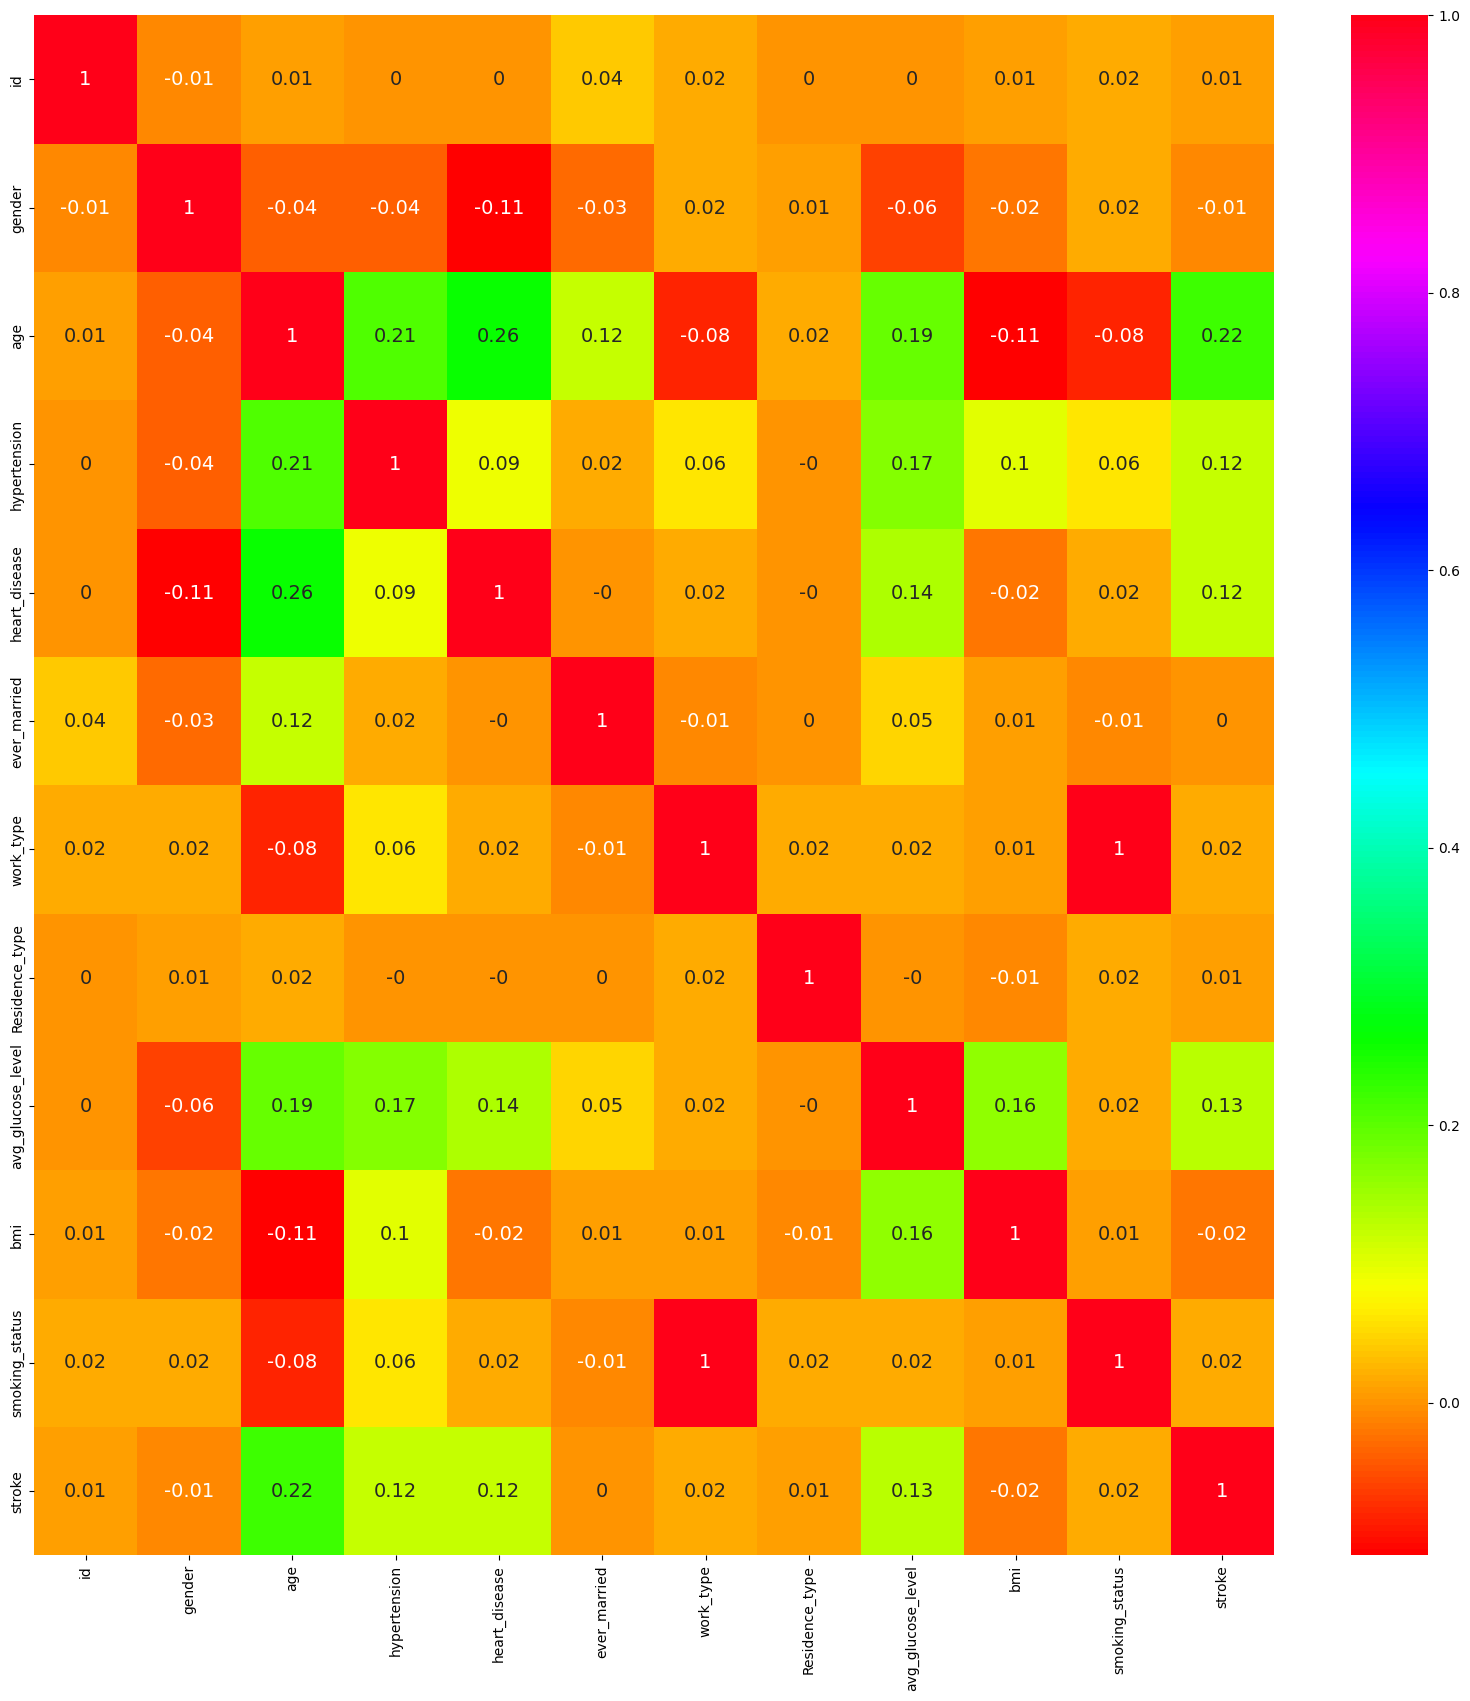

In [300]:
plt.figure(figsize = (20,20))
sns.heatmap(round(corr_map_df.corr(),2), cmap = "hsv", annot = True, annot_kws = {"size":14})
# hsv terrain jet rainbow tab10 Pastel1 Set3 RdBu viridis inferno plasma cividis magma

without class balance

In [160]:



# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(500):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', RobustScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', class_weight='balanced'))  # Linear Regression model
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.71489
# Mean r2 Test_Score: 0.70229
# Average prediction error: ~0.5455 (RMSE)
min/max recall result[0.5423728813559322, 0.864406779661017]


with undersampling

In [ ]:

class_0_df = clean_df[clean_df['stroke'] == 0]
class_1_df = clean_df[clean_df['stroke'] == 1]

undersampled_class_0_data = class_0_df.sample(n=len(class_1_df), random_state=42)
clean_df = pd.concat([undersampled_class_0_data, class_1_df])
clean_df = clean_df.sample(frac=1, random_state=42)

# Now, 'undersampled_data' contains an undersampled version of your original dataset


In [144]:



# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(500):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', RobustScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2'))  # Linear Regression model
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.72952
# Mean r2 Test_Score: 0.70782
# Average prediction error: ~0.5396 (RMSE)
min/max recall result[0.5362318840579711, 0.9107142857142857]


With both undersampling and oversampling

In [170]:

class_0_df = clean_df[clean_df['stroke'] == 0]
class_1_df = clean_df[clean_df['stroke'] == 1]

undersampled_class_0_data = class_0_df.sample(n=len(class_1_df)*2, replace=True, random_state=42)
clean_df = pd.concat([class_1_df, undersampled_class_0_data, class_1_df])
clean_df = clean_df.sample(frac=1, random_state=42)

# Now, 'undersampled_data' contains an undersampled version of your original dataset


In [188]:



# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['work_type', 'smoking_status' ]
to_robust = ['age', 'avg_glucose_level', 'bmi']
# to_min_max = []
already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, verbose = 0, n_jobs=4))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 10
# Mean Recall: 0.73643
# Mean r2 Test_Score: 0.73368
# Average prediction error: ~0.5157 (RMSE)
min/max recall result[0.6583333333333333, 0.8208955223880597]


One by One Features

In [218]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    clean_df = clean_df.dropna(axis=0, subset='bmi')


In [202]:
# clean_df

Categorical

In [231]:
# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['smoking_status']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.49512
# Mean r2 Test_Score: 0.52634
# Average prediction error: ~0.6788 (RMSE)
min/max recall result[0.21739130434782608, 0.9]


First attempts :

work_type : 0.42

smoking_status : 0.49


Numericals

In [234]:

# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['bmi']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', MinMaxScaler(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.55574
# Mean r2 Test_Score: 0.45466
# Average prediction error: ~0.7382 (RMSE)
min/max recall result[0.28125, 0.6923076923076923]


First attempts :

age : 0.67

avg_glucose_level : 0.42

bmi : 0.55574


Binaries

In [240]:
# %%writefile my_python_file.py
# All Columns to preprocess
# to_classify = ['work_type', 'smoking_status' ]
# to_robust = ['age', 'avg_glucose_level', 'bmi']
# # to_min_max = []
# already_processed = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
# Bench : 'MiscFeature'
# select_features = ['work_type'] # + to_min_max
select_features = ['Residence_type']

X = clean_df[select_features]
y = clean_df['stroke']  # Target
r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), select_features),
        # ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    # print(f"{X_train, y_train}")
    pipeline.fit(X_train, y_train)
    r2list.append(pipeline.score(X_test, y_test))

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features)}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1
# Mean Recall: 0.49078
# Mean r2 Test_Score: 0.49721
# Average prediction error: ~0.7090 (RMSE)
min/max recall result[0.3898305084745763, 0.55]


First attempts :

gender : 0.42

hypertension : 0.28

heart_disease : 0.19

ever_married : 0.42845

Residence_type : 0.49


work_type : 0.42

smoking_status : 0.49





age : 0.67

avg_glucose_level : 0.42

bmi : 0.55574




gender : 0.42

hypertension : 0.28

heart_disease : 0.19

ever_married : 0.42845

Residence_type : 0.49

In [241]:
features_to_keep = ['age', 'bmi', 'smoking_status', 'Residence_type']


Regression with proper features

In [247]:
# %%writefile my_python_file.py
# All Columns to preprocess
to_classify = ['smoking_status' ]
to_robust = ['age', 'bmi']
# to_min_max = []
already_processed = ['Residence_type']
# Bench : 'MiscFeature'
select_features = to_classify + to_robust + already_processed # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(), to_classify),
        ('robust_scaler', MinMaxScaler(), to_robust), # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 4 - ['smoking_status', 'age', 'bmi', 'Residence_type']
# Mean Recall: 0.73562
# Mean r2 Test_Score: 0.68470
# Average prediction error: ~0.5614 (RMSE)
min/max recall result[0.5857142857142857, 0.8529411764705882]


In [249]:
# %%writefile my_python_file.py
# All Columns to preprocess
to_robust = ['age', 'bmi']
# to_min_max = []
# Bench : 'MiscFeature'
select_features = to_robust # + to_min_max


X = clean_df[select_features]
y = clean_df['stroke']  # Target

r2list = []
rmse_list = []
recall_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001))

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('robust_scaler', MinMaxScaler(), to_robust) # RobustScaler/StandardScaler
        # ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=8))  # Linear Regression model class_weight='balanced'
    ])
    pipeline.fit(X_train, y_train)

    # R^2 Score, not RMSE
    # train_score = pipeline.score(X_train, y_train)
    # test_score = pipeline.score(X_test, y_test)
    r2list.append(pipeline.score(X_test, y_test))
    # print(f"Training_Score: {train_score:.5f}")

    predicted_strokes = pipeline.predict(X_test)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, predicted_strokes)))
    recall_list.append(recall_score(y_test, predicted_strokes))

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"# Mean r2 Test_Score: {np.mean(r2list):.5f}")
# Display RMSE
print(f"# Average prediction error: ~{np.mean(rmse_list):.4f} (RMSE)")


print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 2 - ['age', 'bmi']
# Mean Recall: 0.69633
# Mean r2 Test_Score: 0.68182
# Average prediction error: ~0.5640 (RMSE)
min/max recall result[0.5737704918032787, 0.8194444444444444]
